Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz
step: 0  loss: 2.4107327461242676
step: 100  loss: 0.8768352270126343
step: 200  loss: 0.7455557584762573
step: 300  loss: 0.5690919160842896
step: 400  loss: 0.6203535795211792
step: 500  loss: 0.547473669052124
step: 600  loss: 0.5787898302078247
train accuracy = 0.8194000124931335, validation accuracy = 0.8174999952316284
step: 0  loss: 0.4128687381744385
step: 100  loss: 0.638286828994751
step: 200  loss: 0.6192695498466492
step: 300  loss: 0.471983939409256
step: 400  loss: 0.48209238052368164
step: 500  loss: 0.469083309173584
step: 600  loss: 0.4953812062740326
train accuracy = 0.8373000025749207, validation accuracy = 0.8347222208976746
step: 0  loss: 0.3485346734523773
step: 100  loss: 0.6024875640869141
step: 200  loss: 0.5939677357673645
step: 300  loss: 0.4472814202308655
ste

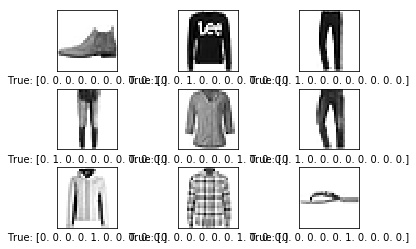

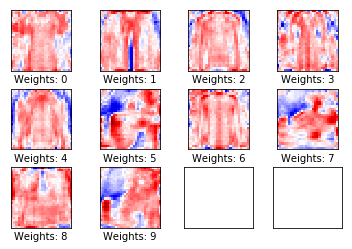

In [95]:
""" 
author:-aam35
"""
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.examples.tutorials.mnist import input_data
import gzip
tf.executing_eagerly()
# Define paramaters for the model
learning_rate = 0.001
batch_size = 64
n_epochs = 5

# random seed to get the consistent result
tf.random.set_random_seed(6)


# Step 1: Read in data
fmnist_folder = 'data/fashion'
data = input_data.read_data_sets(fmnist_folder, one_hot=True, validation_size=0)

# train,validation,test split function using sklearn
def split_data(data):
    # load dataset for train
    #X_train, y_train = load_data(path, kind='train')
    # load dataset for test
    #X_test, y_test = load_data(path, kind='t10k')
    X_train = data.train.images
    #print(len(X_train))
    y_train = data.train.labels
    X_test = data.test.images
    y_test = data.test.labels
    train_img,val_img,train_labels,val_labels= train_test_split( X_train, y_train,
                                                        test_size=0.05, random_state=42)
    # return in tuple
    return (train_img, train_labels), (val_img, val_labels), (X_test, y_test)

#Create train,validation,test split
train, val, test = split_data(data)


# Step 2: Create datasets and iterator
# create training Dataset and batch it
train_data = tf.data.Dataset.from_tensor_slices(train).map(lambda x, y: (x, tf.cast(y, tf.float32)))\
           .shuffle(buffer_size=1000)\
           .batch(batch_size=batch_size)\
# create testing Dataset and batch it
test_data = tf.data.Dataset.from_tensor_slices(test).map(lambda x, y: (x, tf.cast(y, tf.float32)))\
           .shuffle(buffer_size=1000)\
           .batch(batch_size=batch_size)\


# create one iterator and initialize it with different datasets
iterator = tf.data.Iterator.from_structure(train_data.output_types, 
                                           train_data.output_shapes)

train_init = iterator.make_initializer(train_data)	# initializer for train_data
test_init = iterator.make_initializer(test_data)	# initializer for test_data


# Step 3: create weights and bias
# w is initialized to random variables with mean of 0, stddev of 0.01
# b is initialized to 0
# shape of w depends on the dimension of X and Y so that Y = tf.matmul(X, w)
# shape of b depends on Y
w, b = None, None
w = tf.get_variable(name='weights', shape=(784, 10), initializer=tf.random_normal_initializer(0, 0.01))
b = tf.get_variable(name='bias', shape=(10, ))

# Step 4: build model
# the model that returns the logits.
# this logits will be later passed through softmax layer
def softmax_model(image_batch):
    model_output = tf.nn.softmax(tf.matmul(image_batch, w) + b)
    return model_output

# Step 5: define loss function
# use cross entropy of softmax of logits as the loss function
def cross_entropy(model_output, label_batch):
    loss = tf.reduce_mean(-tf.reduce_sum(label_batch * tf.log(model_output), reduction_indices=[1]))
    return loss

# calculate gradient
@tfe.implicit_value_and_gradients
def cal_gradient(image_batch, label_batch):
    return cross_entropy(softmax_model(image_batch), label_batch)

# Step 6: define optimizer
# using Adam Optimizer with pre-defined learning rate to minimize loss
optimizer = tf.train.AdamOptimizer(learning_rate)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#optimizer = tf.train.AdagradOptimizer(learning_rate)

#Step 8: train the model for n_epochs times
for i in range(n_epochs):
    for step, (image_batch, label_batch) in enumerate(tfe.Iterator(train_data)):
        loss, gradients = cal_gradient(image_batch, label_batch)
        # Take an optimization step and update variables.
        optimizer.apply_gradients(gradients)
        if(step%100 == 0):
            print("step: {}  loss: {}".format(step, loss.numpy()))
    ##print("Train and Validation accuracy")
    # for the training
    model_train_output = softmax_model(data.train.images)
    model_train_label = data.train.labels
    correct_train_pred = tf.equal(tf.argmax(model_train_output, 1), tf.argmax(model_train_label, 1))
    train_accuracy = tf.reduce_mean(tf.cast(correct_train_pred, tf.float32))
    # for the validation
    model_val_output = softmax_model(val[0])
    model_val_label = val[1]
    correct_val_pred = tf.equal(tf.argmax(model_val_output, 1), tf.argmax(model_val_label, 1))
    val_accuracy = tf.reduce_mean(tf.cast(correct_val_pred, tf.float32))
    print("train accuracy = {}, validation accuracy = {}".format(train_accuracy.numpy(), val_accuracy.numpy()))

#Step 9: Get the Final test accuracy
model_test_output = softmax_model(data.test.images)
model_test_label = data.test.labels
correct_test_pred = tf.equal(tf.argmax(model_test_output, 1), tf.argmax(model_test_label, 1))
test_accuracy = tf.reduce_mean(tf.cast(correct_test_pred, tf.float32))

print("test accuracy = {}".format(test_accuracy.numpy()))

#Step 10: Helper function to plot images in 3*3 grid
#You can change the function based on your input pipeline

def plot_images(images, y, yhat=None):
    assert len(images) == len(y) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(28,28), cmap='binary')
        # Show true and predicted classes.
        if yhat is None:
            xlabel = "True: {0}".format(y[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(y[i], yhat[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

#Get image from test set 
images = data.test.images[0:9]

# Get the true classes for those images.
y = data.test.labels[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, y=y)

#Second plot weights 
def plot_weights(w):
    # Get the values for the weights from the TensorFlow variable.
    #TO DO ####
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    #w = tf.get_collection('my_w')
    w = w.numpy()
    w_min = np.amin(w)
    #TO DO## obtains thse value from W
    w_max = np.amax(w)
    
    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(28,28)
            #image = w[i].reshape(28,28)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
plot_weights(w)

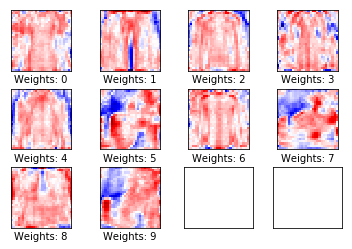

In [79]:
plot_weights(w)